In [1]:
import boto3
import argparse

In [2]:
def submit_job(lr:float, momentum:float, epochs:int, profile_name="default"):
    """
    Submit a job to AWS Batch queue.
    Parameters
    ----------
    lr: float
        Learning rate
    momentum: float
    epochs: float
        Maximum number of training epochs
    profile_name: str
        The profile name used to access AWS.
        The profile is defined in `~/.aws/credentials`.
        Default value is "default".
    """
    session = boto3.Session(profile_name=profile_name)
    client = session.client("batch")
    
    title = "lr" + str(lr).replace(".", "") + "_m" + str(momentum).replace(".", "")
    resp = client.submit_job(
        jobName=title,
        jobQueue="SimpleBatchjob-queue",
        jobDefinition="SimpleBatchjob-definition",
        containerOverrides={
            "command": ["python3", "main.py",
                        "--lr", str(lr),
                        "--momentum", str(momentum),
                        "--epochs", str(epochs),
                        "--uploadS3", "true"]
        }
    )
    print("Job submitted!")
    print("job name", resp["jobName"], "job ID", resp["jobId"])

### Let's run many tasks in parallel

In [3]:
for lr in [0.1, 0.01, 0.001]:
    for m in [0.5, 0.1, 0.05]:
        submit_job(lr, m, 100, profile_name="kaguya")

Job submitted!
job name lr01_m05 job ID 8c96d99e-33ec-4a44-afad-5b9bf4ef30fc
Job submitted!
job name lr01_m01 job ID 2e8a6f65-4f67-49f5-bd70-ca8e42379ce1
Job submitted!
job name lr01_m005 job ID 54a3536a-b6db-4f5b-83db-c7e2689e3bce
Job submitted!
job name lr001_m05 job ID ea2573e2-a1d3-4463-9d61-9bb1d676fc7c
Job submitted!
job name lr001_m01 job ID a94aac61-e35f-4909-9d55-2c3a28299c56
Job submitted!
job name lr001_m005 job ID 6fd93ea0-2a87-4ed3-9fd5-28c8a5edcb04
Job submitted!
job name lr0001_m05 job ID b2e26982-fcff-4040-8344-467eed37e906
Job submitted!
job name lr0001_m01 job ID bf038b50-97d0-4d37-ab88-2b5434ec765d
Job submitted!
job name lr0001_m005 job ID bb4946f7-f0e6-4223-893d-5ac6606cc28f


### Let's download the learning result and make plots

In [4]:
import pandas as pd
import numpy as np
import io
from matplotlib import pyplot as plt

In [5]:
def read_table_from_s3(key, profile_name="default"):
    session = boto3.Session(profile_name=profile_name)
    s3 = session.resource("s3")
    bucket = s3.Bucket("simplebatchbucket")
    
    obj = bucket.Object(key).get().get("Body")
    df = pd.read_csv(obj)
    
    return df

In [10]:
grid = np.zeros((3,3))
for (i, lr) in enumerate([0.1, 0.01, 0.001]):
    for (j, m) in enumerate([0.5, 0.1, 0.05]):
        key = f"metrics_lr{lr:0.4f}_m{m:0.4f}.csv"
        df = read_table_from_s3(key, profile_name="kaguya")
        grid[i,j] = df["val_accuracy"].max()

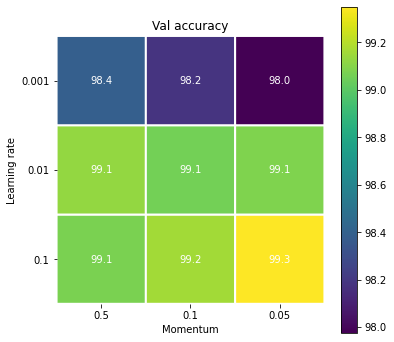

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

c = ax.pcolor(grid, edgecolors='w', linewidths=2)

for i in range(3):
    for j in range(3):
        text = ax.text(j+0.5, i+0.5, f"{grid[i, j]:0.1f}",
                       ha="center", va="center", color="w")

ax.set_title("Val accuracy")
ax.set_xticks([0.5,1.5,2.5])
ax.set_xticklabels([0.5, 0.1, 0.05])
ax.set_xlabel("Momentum")
ax.set_yticks([0.5,1.5,2.5])
ax.set_yticklabels([0.1, 0.01, 0.001])
ax.set_ylabel("Learning rate")

ax.set_frame_on(False)
fig.colorbar(c, ax=ax)